<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with Delta Lake, PySpark, and MLlib</h1>

# Spark Environment

Make sure that you open this notebook in your Spark environment!

In [1]:
!pip install -U -q pyspark delta-spark # If you use Colab uncomment this line

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 60.8 MB/s 


## Learning Objectives

At the end of this session, you will be able to 

- Load, save, partition data with Delta Lake tables
- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [2]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-09-22 18:09:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8% 2.45M 0s
    50K .......... .......... .......... .......... .......... 17% 5.22M 0s
   100K .......... .......... .......... .......... .......... 26% 5.00M 0s
   150K .......... .......... .......... .......... .......... 35%  102M 0s
   200K .......... .......... .......... .......... .......... 44% 5.97M 0s
   250K .......... .......... .......... .......... .......... 53% 77.7M 0s
   300K .......... .......... .......... .......... .......... 61% 93.2M 0s
   350K .......... .......... .......... .......... .......... 70%  100M 0s
   400K ........

In [3]:
ls

bank.zip  sample_data/


1. Unzip the file and use `ls` to see the files.

In [4]:
%%sh
unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [6]:
ls -lh

total 5.5M
-rw-r--r-- 1 root root 451K Feb 14  2012 bank.csv
-rw-r--r-- 1 root root 4.4M Feb 14  2012 bank-full.csv
-rw-r--r-- 1 root root 3.8K Feb 14  2012 bank-names.txt
-rw-r--r-- 1 root root 566K Feb 14  2012 bank.zip
drwxr-xr-x 1 root root 4.0K Sep 14 13:44 sample_data/


In [5]:
%%sh
wc -l bank.csv

4522 bank.csv


In [7]:
%%sh
head bank.csv

"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"
33;"services";"married";"secondary";"no";4789;"yes";"yes";"cellular";11;"may";220;1;339;4;"failure";"no"
35;"management";"single";"tertiary";"no";1350;"yes";"no";"cellular";16;"apr";185;1;330;1;"failure";"no"
30;"management";"married";"tertiary";"no";1476;"yes";"yes";"unknown";3;"jun";199;4;-1;0;"unknown";"no"
59;"blue-collar";"married";"secondary";"no";0;"yes";"no";"unknown";5;"may";226;1;-1;0;"unknown";"no"
35;"management";"single";"tertiary";"no";747;"no";"no";"cellular";23;"feb";141;2;176;3;"failure";"no"
36;"self-employed";"married";"tertiary";"no";307;"yes";"no";"cellular";14;"may";341;1;330;2;"other";"no"
39;"technician";"married";"secondary";"no";147;"yes";"no";"cellular";6;"may";151;2;-1;0;"unknown";"no"
41;"entrepreneur";"marrie

1. Create a Delta table for `bank.csv` (Why Delta Lake? Here's a read [here](https://medium.com/@databeans-blogs/delta-lake-the-data-engineers-missing-piece-part-1-ebab66a3f8c0?source) from a data engineer's perspective)

    We first set up a Python project `ml-bank`, configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake:

In [8]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("ml-bank") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

   We define output formats and paths, you need to complete code to load the data from its source (since the delimiter of the file is semicolon, use [`spark.read.csv`](https://spark.apache.org/docs/latest/sql-data-sources-csv.html) that provides more flexibility) and write the data to its target (hint: [Create a table](https://docs.databricks.com/delta/quick-start.html#create-a-table)).

In [10]:
# Define the input and output formats and paths and the table name.
write_format = 'delta'
load_path = 'bank.csv'
save_path = '/tmp/delta/bank-4k'
table_name = 'default.bank4k'

# Load the data from its source.
df = spark.read.csv(load_path, header=True, inferSchema=True, sep=";")

# Write the data to its target.
df.write.format(write_format).mode('overwrite').save(save_path)

1. Verify what we just created.

In [11]:
ls -lh /tmp/delta/bank-4k/

total 64K
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 _delta_log/
-rw-r--r-- 1 root root  57K Sep 22 18:11 part-00000-70197362-6c42-4975-872a-6411006a9096-c000.snappy.parquet


1. Partition data by `job` status. 

  To speed up queries that have predicates involving the partition columns, we should partition data. Often time, we partition by anonymized user id; here we demonstrate the idea with `job`.

In [12]:
import shutil
shutil.rmtree(save_path) # To replace data, we need to remove the existing directory

partition_by = 'job' # YOUR CODE HERE

# Write the data to its target.
df.write.partitionBy(partition_by).format(write_format).mode('overwrite').save(save_path)

In [13]:
ls -lh /tmp/delta/bank-4k

total 52K
drwxr-xr-x 2 root root 4.0K Sep 22 18:11  _delta_log/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=admin.'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=blue-collar'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=entrepreneur'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=housemaid'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=management'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=retired'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=self-employed'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=services'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=student'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=technician'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=unemployed'/
drwxr-xr-x 2 root root 4.0K Sep 22 18:11 'job=unknown'/


  We only touch the surface of Delta Lake, for more information, check [Delta Lake guide](https://docs.databricks.com/delta/index.html)

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.


1. Load data from its source by specifying the data format and path; then check out the schemas.

In [14]:
read_format = 'delta'
load_path = '/tmp/delta/bank-4k/'

df = spark.read.format(read_format).load(load_path) 

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [16]:
df.show()

+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 35|management|  single| tertiary|     no|   1350|    yes|  no| cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|management| married| tertiary|     no|   1476|    yes| yes|  unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 35|management|  single| tertiary|     no|    747|     no|  no| cellular| 23|  feb|     141|       2|  176|       3| failure| no|
| 40|management| married| tertiary|     no|    194|     no| yes| cellular| 29|  aug|     189|       2|   -1|       0| unknown| no|
| 38|management|divorced|  unknown|     no|      0|    yes|  no| cellular| 18|  nov

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [32]:
import pandas as pd

pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [33]:
import pyspark.pandas as ps

psdf = df.pandas_api()
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


4. How many datapoints are there in the dataset? Use the `.count()` method.

In [ ]:
psdf.count()

5. Use the `.describe()` method to see summary statistics on the features.

In [34]:
psdf.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


6. The above result includes the columns that are categorical, so don't have useful summary statistics. Let's limit to just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in Pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [35]:
col_names = [name for name in psdf.dtypes.index]
dtypes = [dtype for dtype in psdf.dtypes.tolist()]

numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32']

psdf[numeric_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark Datafrane to a Pandas DataFrame using the `to_pandas()` command so that we can plot.  What do you see?

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


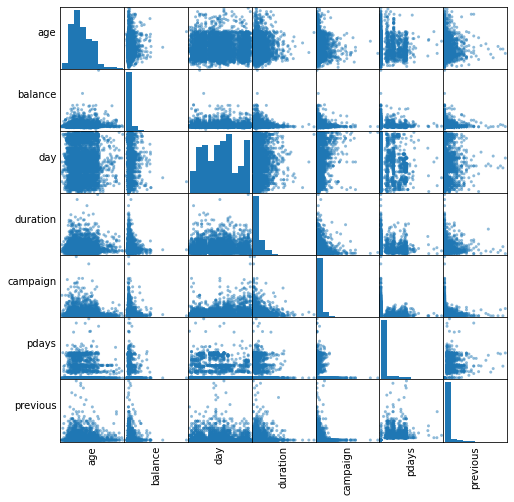

In [36]:
# Convert Pandas on Spark DataFrame to Spark DataFrame
numeric_data = psdf[numeric_features].to_pandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

There aren't any highly correlated variables, so we will keep them all for the model. It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, so we will remove these two columns.

8. Use the `.drop()` method to drop the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes` method to verify that `sdf` now has the correct columns.

In [37]:
sdf = psdf.drop(columns=['month','day'])
sdf.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

## Part 3: Preparing Data for Machine Learning

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [38]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.  So that we can run the pipeline on our Pandas on Spark DataFrame, we will convert it back to a Spark DataFrame using the **`to_spark()`** command

1. Fit a pipeline on df.

In [39]:
from pyspark.ml import Pipeline
sdf = psdf.to_spark()
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(df)

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [40]:
transformed_df = pipelineModel.transform(df)
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vecto

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [41]:
selectedCols = ['label', 'features'] + sdf.columns
sdf = transformed_df.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. Let's view the first five rows of the `sdf` DataFrame using the methods we learned in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [42]:
sdf.show()
pd.DataFrame(sdf.take(5), columns=sdf.columns)

+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|label|            features|age|       job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|   1350|    yes|  no| cellular| 16|  apr|     185|       1|  330|       1| failure| no|
|  0.0|(30,[0,11,14,16,1...| 30|management| married| tertiary|     no|   1476|    yes| yes|  unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|    747|     no|  no| cellular| 23|  feb|     141|       2|  176|       3| failure| no|
|  0.0|(30,[0,11,14,16,1...| 40|management| married|

,label,features,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [43]:
train, test = sdf.randomSplit([0.7,0.3])

6. What are the sizes of the training and test sets?

In [45]:
train.count(), test.count()

(3135, 1386)

## Part 5: Logistic Regression Model

- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a LogisticRegression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [46]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel= lr.fit(train)

2. We can obtain the coefficients by using LogisticRegressionModel’s attributes. Look at the following plot of the beta coefficients.

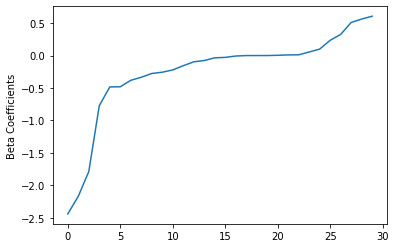

In [47]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [48]:
predictions = lrModel.transform(test)

4. View the first 10 rows of the `predictions` DataFrame.

In [49]:
predictions.head(10)

[Row(label=0.0, features=SparseVector(30, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: 31.0, 25: 466.0, 26: 164.0, 27: 1.0, 28: -1.0}), age=31, job='management', marital='married', education='secondary', default='no', balance=466, housing='yes', loan='no', contact='cellular', day=14, month='may', duration=164, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no', rawPrediction=DenseVector([2.922, -2.922]), probability=DenseVector([0.9489, 0.0511]), prediction=0.0),
 Row(label=0.0, features=SparseVector(30, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: 33.0, 25: 11.0, 26: 104.0, 27: 3.0, 28: -1.0}), age=33, job='management', marital='married', education='secondary', default='no', balance=11, housing='yes', loan='no', contact='cellular', day=4, month='may', duration=104, campaign=3, pdays=-1, previous=0, poutcome='unknown', y='no', rawPrediction=DenseVector([3.3153, -3.3153]), probability=DenseVector([0.9649, 0.0351]), 

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.8923928476884939

## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [51]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 31|management|  0.0|[1.16689784886501...|       0.0|[0.91163757541824...|
| 33|management|  0.0|[1.26049384553311...|       0.0|[0.92560010033749...|
| 34|management|  0.0|[1.05327172489779...|       0.0|[0.89153754260138...|
| 34|management|  0.0|[0.91776821388639...|       0.0|[0.86241995288222...|
| 42|management|  0.0|[1.31125621180928...|       0.0|[0.93229646236370...|
| 51|management|  0.0|[0.94278475987107...|       0.0|[0.86824954420916...|
| 60|management|  0.0|[0.94405223096989...|       0.0|[0.86853925141526...|
| 39|management|  0.0|[1.31125621180928...|       0.0|[0.93229646236370...|
| 31|management|  0.0|[0.15474507893673...|       0.0|[0.57676080957657...|
| 40|management|  0.0|[1.29225360370912...|       0.0|[0.92985780953859...|
+---+-------

2. Run some cross validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8834115466993964

## Acknowledgements


This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)